In [1]:
%matplotlib inline

In [3]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import mpl_toolkits.mplot3d

import skimage
import skimage.io
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Principle Component Analysis

## Helper functions
I will start by defining couple of support functions. They will help visualize the operations we will be doing below. I suggest keeping this section folded (hidden) to improve readability.

In [23]:
def plot_radius_vectors(vectors, colors, move_origin=False):
    """
    Plots 2D radius vectors on the xy-plane. Each vector is in the format (end_x, end_y).
    """
    # Extract vector coordinates
    flattened = np.array(vectors).ravel()
    end_x, end_y = flattened[::2], flattened[1::2] 

    # Plot an arrow
    start_x = np.zeros(end_x.shape)
    start_y = np.zeros(end_x.shape)
    plt.quiver(start_x, start_y, end_x, end_y, scale=1, scale_units='xy', angles = "xy", color=colors)

    # Make the plot pretty (housekeeping)
    all_x = np.concatenate((start_x, end_x))
    all_y = np.concatenate((start_y, end_y))
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    correction = 1
    plt.xlim(min_x - correction, max_x + correction)
    plt.ylim(min_y - correction, max_y + correction)
    
    
    # Move origin
    ax = plt.gca()
    if move_origin:
        ax.spines['bottom'].set_position('zero')
        ax.spines['left'].set_position('zero')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

In [24]:
def visualize_transformation(matrix, plot_title):
    """
    Visualize the linear transformation in 2D space with transformation matrix `matrix`
    by plotting the current and newgrid and  (before and after the transformation).
    
    `matrix` - 2x2 matrix of the linear tranformation
    """
    # Create new figure
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.axis("equal")
    
    # Modify tranformation matrix to work with Affine2D
    modified = np.concatenate((matrix, np.zeros((2,1))), axis = 1)
    modified = np.concatenate((modified, [[0, 0, 1]]),axis=0)
    
    # Current unit vectors and grid
    ax.quiver([0, 0], [0, 0], [1, 0], [0, 1], color = ["red", "blue"], alpha = 0.2, units = "xy", scale = 1)
    ax.grid()
    
    # Transform the space
    t = Affine2D(modified)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    [min_x, max_x, min_y, max_y] = [2 * ax.get_xlim()[0], 2 * ax.get_xlim()[1] + 1, 2 * ax.get_ylim()[0], 2 * ax.get_ylim()[1] + 1]
    
    # New grid lines
    # Horizontal
    for y in np.arange(min_y, max_y):
        ax.plot([min_x, max_x], [y] * 2, color = "red", linestyle = "--", linewidth = 2, transform = t + ax.transData)
    # Vertical
    for x in np.arange(min_x, max_x):
        ax.plot([x] * 2, [min_y, max_y], color = "blue", linestyle = "--", linewidth = 2, transform = t + ax.transData)

    # New unit vectors
    new_x = t.transform_affine([1, 0])
    new_y = t.transform_affine([0, 1])
    ax.quiver([0, 0], [0, 0], [new_x[0], new_y[0]], [new_x[1], new_y[1]], color = ["red", "blue"], units = "xy", angles = "xy", scale = 1)
    
    # Make the plot pretty (housekeeping)
    ax.set_xticks(np.arange(ax.get_xlim()[0], ax.get_xlim()[1] + 1))
    ax.set_yticks(np.arange(ax.get_ylim()[0], ax.get_ylim()[1] + 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])  
    ax.set_title(plot_title)

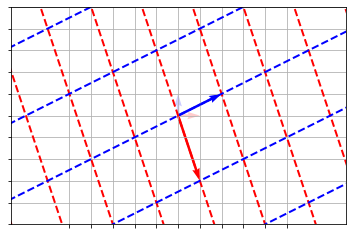

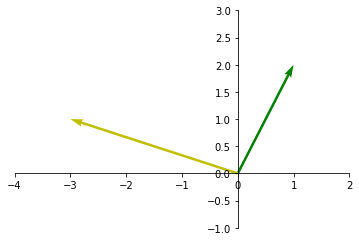

In [25]:
# Unit test to validate the two plotting function operate properly
A = np.array([
    [1, 2],
    [-3, 1],
])

visualize_transformation(A, '')
plt.show()

plot_radius_vectors(A.tolist(), colors=list('gy'), move_origin=True)
plt.show()

## Intuition
There are some prerequsites needed to understand now PCA works. I try to create the intuition;
complete explanation would require the majority of the linear algebra fundamentals.

### Dataset, features, response

Lets consider a dataset we will later use: Italian wines.

The dataset contains measurments of 172 wines, each measurement being the concentration of 13 constituent substances. Each row (usually called the entry) is a measurement, each column (usually called feature) contains one of the 13 wine properties.

Column 0 - the target - contains the variety of wine (encoded with number between 0 to 2). It is called target (or response / output) because the purpose of our analysis is ofter trying to predict the output based on input measurements of the feature. The features (columns) are also called inputs as they.

**Predictive analysis**: Use data and algorithms to calculate **likelyhood** of future outcomes based on historycal data. The target column contains the outcomes, the hystorical data is the available dataset.

Target: 
> Wine variety, 

Features: columns 1-13
> Alcohol
> Malic acid
> Ash
> Alcalinity of ash
> Magnesium
> Total phenols
> Flavanoids
> Nonflavanoid phenols
> Proanthocyanins
> Color intensity
> Hue
> OD280/OD315 of diluted wines
> Proline

In [26]:
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


<div>
    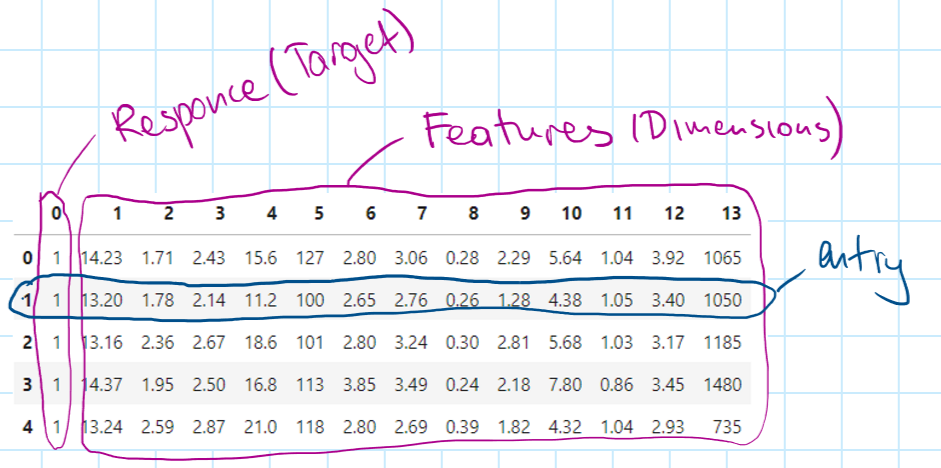
</div>

### Too manu features
Having large number of columns (features, inputs) is a problem TODO list problems.

The simplest options to reducte the number of features is the just to remove columns that is select only those with the most impact. This is called feature selection.

PCA is better. The main idea is the same: compress the dataset (It is also correct to say "to reduce the number of dimensions."). However, before selection, we first construct new features from the old ones (a combination of the old ones). Why do we bother though? Because the new features (with the help of linear algebra) follow the data better.

To use linear algebra we make an abstraction: each measurement (row) in the dataset shall be vector and the features are the axes or dimensions.

### Eigen values and vectors

Lets look a following 2D example. Let $A$ be a random 2x2 matrix, for example the one defined below. If we multipy a vector $\vec x = \begin{bmatrix} 1 \\ 2 \end{bmatrix}$ by $A$ (or any vector for that matter), the vector will be sent to a "new place" in the xy plane. Technically speaking, we are treating $A$ as a matrix of a linear tranformation:
$$ A \vec x = \vec b $$

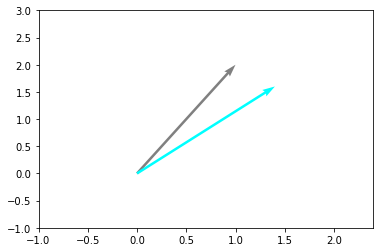

In [27]:
A = np.array([
    [0.8, 0.3],
    [0.2, 0.7],
])

x = np.array([1, 2])
b = A @ x
plot_radius_vectors([x, b], colors=['gray', 'aqua'])

It is clear the new vector $ \vec b $ has "moved". We can further transform $ \vec b $ to see the outcome: 

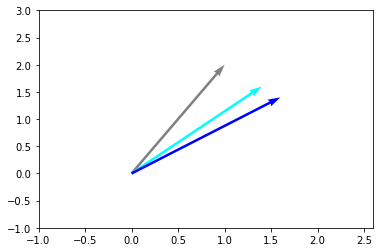

In [28]:
plot_radius_vectors([x, b, A @ b], colors=['gray', 'aqua', 'blue'])

Let's try another vector: $\vec x = \begin{bmatrix} -1 \\ 1 \end{bmatrix}$:

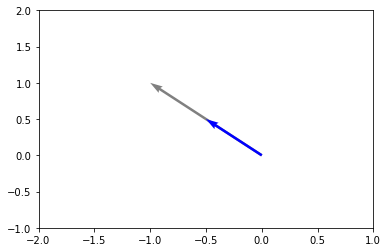

In [29]:
x = np.array([-1, 1])
b = A @ x
plot_radius_vectors([x, b], ['gray', 'blue'])

Well, that is interesting, the two vectors seem to lie on the same line. Is this a coincidence? Acutually not - I chose  $ \begin{bmatrix} -1 \\ 1 \end{bmatrix}$ on purpose, I knew what would happen in advance. Let's compare the distances of the two vectors.

In [30]:
x_len = np.sqrt(x @ x)
b_len = np.sqrt(b @ b)
b_len / x_len

0.49999999999999994

It seems to have shrunk in half (assuming there is some calculation error). Here comes a sensible question: are there more "special" vectors with the same behavior? Also, how can those be calculated? Let's write the transformation from above:
$$ A \vec x = \vec b = \lambda x$$

### Projection

Projection of a vector on another vector can be viewed from different prospectives. The most intuitive way is the geometrical. From the prospective of the linear algebra, projection is a transformation, linear operator in particular. As every other transformation, the projection has a matrix. Multiplying this matrix over any vector causes it to "move" to a new location. As we are using the same recepient vector, the projection basically compresses the 2D space to a line (in the 2D case).

Consider the example below. We will be projecting the RED vector $\vec a$ over the GRAY $\vec b$. Projection matrix has a rank: rank 1.

The projection matrix is:
$$ P = a  TODO$$

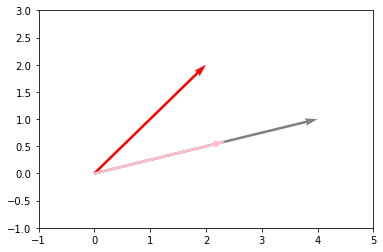

In [31]:
a = np.array([
    [4],
    [1],
])
b = np.array([
    [2],
    [2],
])


def calc_projection(a):
    """
    Returns the projection matrix to project on vector `a`.
    """
    return (a @ a.T) / (a.T @ a)

# Projection matrix (rank 1)
P = calc_projection(a)
b_projection = P @ b
plot_radius_vectors([a, b, b_projection], ['grey', 'red', 'pink'])
plt.show()

The projection matrix projects any vector $b$ onto the line $a$ is lying on. Basically, the 2d space is compressed in a single line (from 2 to 1 dim).

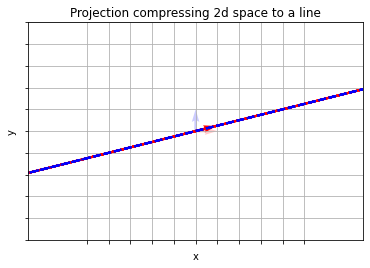

In [32]:
visualize_transformation(P, "Projection compressing 2d space to a line")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

**Note:** The selection of $\vec{a}$ is not affecting the projection $\vec{p}$. This makes sense as $\vec{a}$ was chosen at random and also because the projection is on the **line** that $\vec{a}$ lies on.

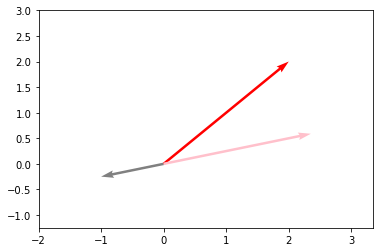

In [33]:
a = np.array([
    [-1],
    [-0.25],
])
P = ((a @ a.T) / (a.T @ a))
p = P @ b
plot_radius_vectors([a, b, p], ['grey', 'red', 'pink'])

### Diagonalization

**Factorization**: represent $A$ as product of other matrixes

**Diagonalization**: represent $A$ as product of the following specific type: $A=PDP^{-1}$

Note that:
* $A$ must be square
* $D$ is a diagonal matrix



<div>
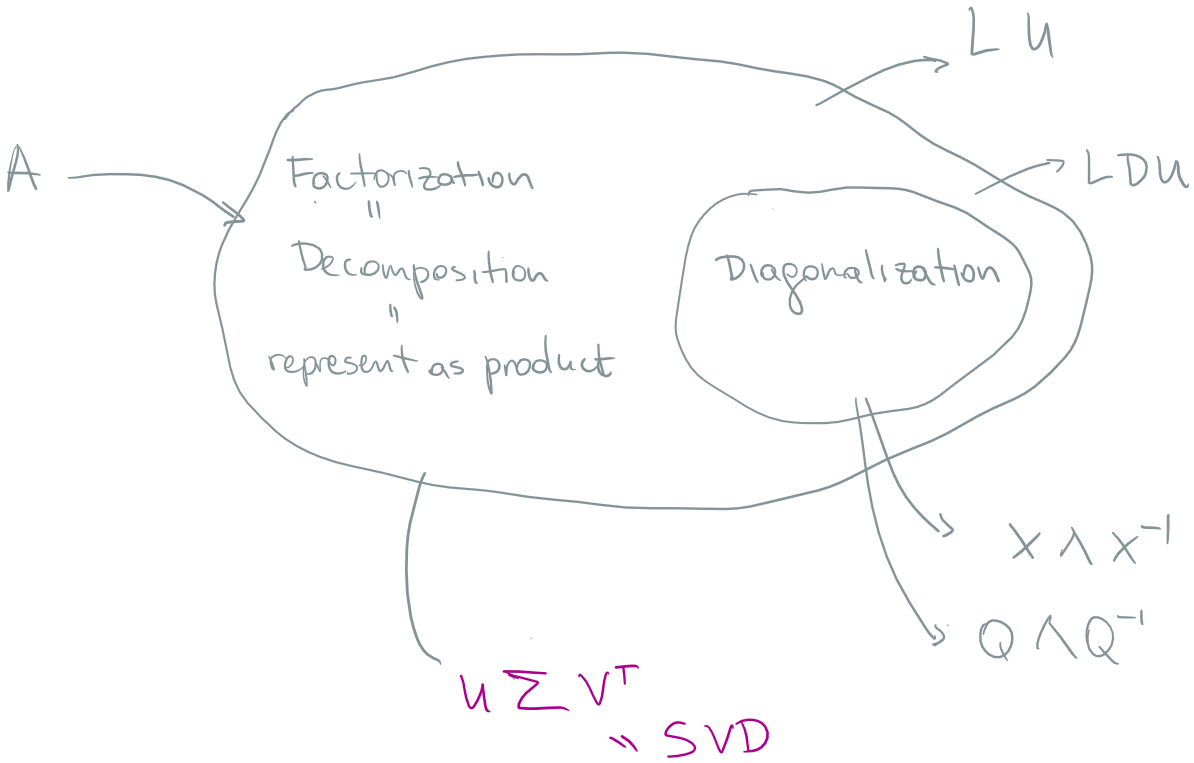
</div>

### Normalization = Centering + Scaling

Values are in various scales as the objects or phenomenon we are measuring are also various. Thus, data often is normalized - meaning 

Z-score.

### SVD

Finally, comparing the two expressions of the original equation $A = U \Sigma V^{-1}$ we are solving.
The two are equal!
In summary, we managed to decomponse (=represent as product of several matrixes; factorize) a random non-symmetric matrix to a product.

Note: The eigen values of $AA^T$ and $A^TA$ are equal.

In [34]:
# Difine matrix A
A = np.array([
    [3, 0],
    [4, 5],
])

# Calculate matrix V containg current basis vectors
eigvalues, eigvectors = np.linalg.eig(A.T @ A)
V = eigvectors.T

# Calculate matrix U
eigvalues, eigvectors = np.linalg.eig(A @ A.T)
U = eigvectors.T

# Find the sigma matrix
sigma1, sigma2 = [np.sqrt(e) for e in eigvalues]
S = np.array([
    [sigma1, 0],
    [0, sigma2],
])

U @ S @ (V.T)

A @ V, S @ U

(array([[ 2.12132034,  2.12132034],
        [-0.70710678,  6.36396103]]),
 array([[-2.12132034,  0.70710678],
        [-2.12132034, -6.36396103]]))

## PCA

**Principal component analysis** (PCA) is the **process of computing** the principal components and using them to perform a change of basis on the data.

Each data point is projected onto only the first few principal components. This way, the inital data is transformed to a lower-dimensional data but most of the data's variation is preserved.

The principal components are eigenvectors of the data's covariance matrix.

Lets look at an example. $A_0$ is 2x6 matrix. Row 1 contains history grades, row2 - math grades. Each column is one student.

Sample covariance $S$.

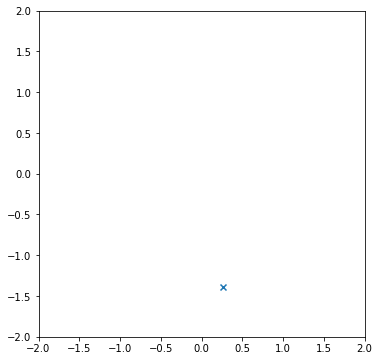

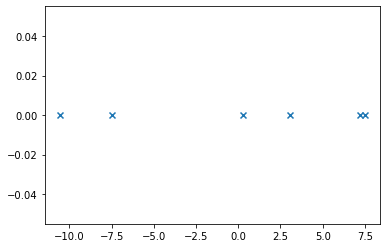

In [129]:
A_0 = np.array([
    [53, 46, 57, 51, 46, 47],
    [77, 64, 78, 69, 69, 63],
])
means = A_0.mean(axis=1, keepdims=True)
A = A_0 - means

# Sample covariance
n = A.shape[1] # number of columns
S = A @ A.T / (n - 1)

eigvalues, eigvectors = np.linalg.eig(S)
principle_component = eigvectors[:,[1]]
A_t = principle_component.T.ravel() @ A

l = eigvectors[:,::-1].T @ A

plt.figure(figsize=(6,6))
plt.scatter(l[0], l[1], marker='x')
ax = plt.gca()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
ax.set_aspect("equal")
plt.show()

plt.scatter(A_t, np.zeros(A_t.size), marker='x')
plt.show()

## Example: Dimensions reduction

Lets apply PCA!

Imagine we are in Italy drinking wine. We are asked to guess the grape sort of the wine (we are given three options).  We are given a dataset with prior measuremen with 172 wines and 13 substances measured for each. The grape variaty (species) is also given - it is one of three sorts.

The 13 substances:
> 1) Alcohol
> 2) Malic acid
> 3) Ash
> 4) Alcalinity of ash  
> 5) Magnesium
> 6) Total phenols
> 7) Flavanoids
> 8) Nonflavanoid phenols
> 9) Proanthocyanins
> 10) Color intensity
> 11) Hue
> 12) OD280/OD315 of diluted wines
> 13) Proline

To make such predition, we will develop a model that takes


The problem is based on the [this](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad) tutorial.

Data is freely available from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/wine).

### My adaptation

I am using [this](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad) tutorial. However, I simplified the algorith and used more descriptive varaible names. The original version is further below.

In [133]:
# Read data
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
data = wine.iloc[:, 1:].values

In [134]:
# Normalize data
s = data.std(axis=0)
x_bar = data.mean(axis=0)
data_std = (data - x_bar) / s

# Test
(data_std != StandardScaler().fit_transform(data)).sum()  # expected: 0

0

In [135]:
# Find covariance matrix
covariance_matrix = data_std.T @ data_std

# # Alternative
# covariance_matrix = np.cov(data_std.T)

# Test
covariance_matrix.shape  # expected (13, 13)

(13, 13)

In [136]:
# Find eigen values and vectors
eigen_vals, eigen_vecs = np.linalg.eig(covariance_matrix)

# Test
eigen_vecs.shape  # expected (13, 13)

(13, 13)

In [137]:
# Calculate cumulative sum of explained variances
total = sum(eigen_vals)
explained_var = [(value / total) for value in sorted(eigen_vals, reverse=True)]
explained_var_cum = np.cumsum(explained_var)

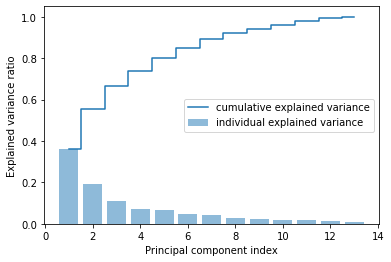

In [138]:
# Plot explained variances
plt.bar(range(1,14), explained_var, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,14), explained_var_cum, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

As stated before, total explained variance is a measure of the discrepancy between the model and actual data. For example, if we make the model using the first 3 the first three principle components, the percentage of variation we will cover (that is the total explained variance will be ~ 66%.

In [143]:
# explained variance for the first 3 principle components
explained_var_cum[2]

0.6652996889318524

In [298]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

`[:, np.newaxis]` is used to transform the row vector to column vector, that is to **transpose it**.

In [299]:
# Select first two princple components
pc = [
    eigen_pairs[0][1][:, np.newaxis],
    eigen_pairs[1][1][:, np.newaxis],
]
proj_matrix = np.hstack(pc)

# Test
proj_matrix.shape  # expected (13, 2)

(13, 2)

In [300]:
# Transform 
wine_pca = data_std.dot(proj_matrix)

# Test
wine_pca.shape, data_std.shape  # expected ((178, 2), (178, 13))

((178, 2), (178, 13))

Finally, we plot the transformed data. The data has now only 2 indead of 13 features (columns). It is compressed that is projected on the two new axes: principle component 1 and 2.

The target or the output is the wine sort (variaty) 

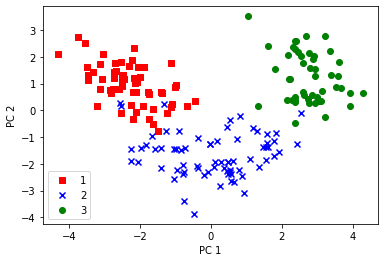

In [302]:
# Plot
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

target = wine.iloc[:, 0].values
for l, c, m in zip(np.unique(target), colors, markers):
    x = wine_pca[target==l, 0]
    y = wine_pca[target==l, 1]
    plt.scatter(x, y, c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

### Original code

The original code from the article splits the data in two. **Train data** is used to generate the PCA projection matrix (=**fit the model**); it contains 124 rows. Then, the already created **model** is used to **predict** the type of wine of the remaining **train data** based on the two new features (=principle components). Of course, the train data is part of the initial dataset so we **know** the type of wine. Therefore we can compare what the model **predicts** to reality.

**Note:** since the code below uses only part of the dataset to create the model, the plots below (especially the second one - princple components) differ from my adaptation above. 

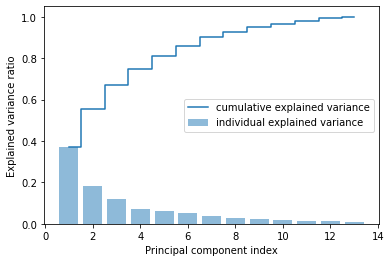

In [266]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

# split into training and testing sets
X = df_wine.iloc[:, 1:].values
y = df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,14), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [268]:
# Test to check the shapes of the test and train sets
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(124, 13)
(54, 13)
(124,)
(54,)


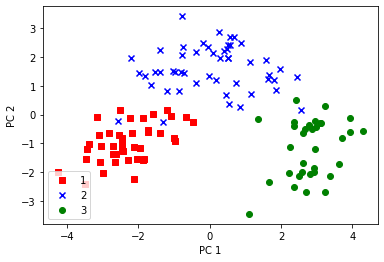

In [265]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs1 = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs1.sort(key=lambda k: k[0], reverse=True)

# Generate projection matrix
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
w1 = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

X_train_pca = X_train_std.dot(w)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], 
                X_train_pca[y_train==l, 1], 
                c=c, label=l, marker=m) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

## Example: Eigenfaces

Images from [here](https://www.kaggle.com/datasets/kasikrit/att-database-of-faces).

raw pixel values as input features

simply PCA applied to the face recognition problem

normalized pixels values 

In [16]:
path = pathlib.Path('./faces')
path
path.resolve()

WindowsPath('C:/Users/a1056968/Desktop/Math-Cocepts-for-Developers/principle-component-analysis/faces')

In [52]:
base_directory = './faces'
pattern = '**/*.pgm'

images = np.array([])
entries = Path(base_directory).glob(pattern)
for entry in entries:
    images += skimage.io.imread(entry)
    break
    
print(images.shape)
print(images)

ValueError: operands could not be broadcast together with shapes (0,) (112,92) (0,) 

In [ ]:
Path('./faces').*

In [48]:
for dirpath, dirnames, filenames in os.walk('./faces'):
    image = skimage.io.imread(filenames)
    plt.imshow(image)

OSError: Cannot understand given URI: ['README'].

In [45]:
with open('./faces/s1/1.pgm') as f:
    print(f)
    


<_io.TextIOWrapper name='./faces/s1/1.pgm' mode='r' encoding='cp1252'>


In [28]:
base

s = '8.'
files = [x for x in p if x.is_file() and x.name.startswith(s)]
files[:3]

NameError: name 'base' is not defined

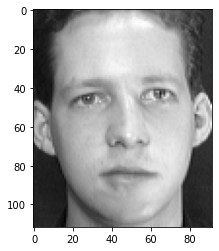

In [ ]:
images = np.array([skimage.io.imread(file) for file in files])

for image in images[:1]:
    plt.imshow(image, cmap='gray')
    plt.show()

In [ ]:
# # Lower resolution
# resolution = (128,96)
# rescaled = np.array([cv2.resize(img, dsize=resolution, interpolation=cv2.INTER_CUBIC) for img in images])
# plt.imshow(rescaled[0], cmap='gray')

In [ ]:
# Change image to 1D
x, y, z = images.shape
A_00 = images.reshape(x, y * z)
images.shape, A_00.shape

((40, 112, 92), (40, 10304))

In [ ]:
A_0 = A_00
A_0.shape

(40, 10304)

In [ ]:
_, h, w = images.shape
X = data
y = lfw_dataset.target
target_names = lfw_dataset.target_names
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(A_0, y, test_size=0.3)

In [ ]:
means = A_0.mean(axis=0, keepdims=True)
A = A_0 - means
A[:,300].mean(), A_0[:,300].mean()

(0.0, 74.0)

In [ ]:
# plt.figure(figsize=(10,60))
# plt.imshow(A_0,cmap='gray')
# plt.show()
# plt.imshow(A)

Sample covariance $S$:

In [ ]:
n = A.shape[1] # number of columns
S = A @ A.T / (n - 1)
S.shape

(40, 40)

In [ ]:
eigvalues, eigvectors = np.linalg.eig(S)
eigvalues.shape, eigvectors.shape

((40,), (40, 40))

In [ ]:
components_num = 10
components = eigvectors[:components_num]
components.shape, A.shape

((10, 40), (40, 10304))

In [ ]:
A_t = components @ A
A_t.shape

(10, 10304)

((10, 112, 92), (112, 92))

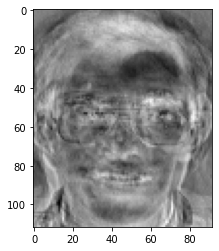

In [ ]:
final = A_t.reshape((components_num, 112, 92))
mean_face = final.mean(axis=0)
plt.imshow(mean_face, cmap='gray')

final.shape, final.mean(axis=0).shape

In [55]:
for f in final[:1]:
    plt.imshow(f, cmap='gray')
    plt.show()

NameError: name 'final' is not defined

## Example: Iris flower

The Iris Перуника 
<p><a href="https://commons.wikimedia.org/wiki/File:Iris_germanica_001.jpg#/media/Файл:Iris_germanica_001.jpg"><img src="https://upload.wikimedia.org/wikipedia/commons/2/29/Iris_germanica_001.jpg" alt="Немски ирис (I.&nbsp;germanica)" height="480" width="371"></a><br>By &lt;a href="//commons.wikimedia.org/wiki/User:Za" title="User:Za"&gt;Za&lt;/a&gt; - &lt;span class="int-own-work" lang="bg"&gt;Собствена творба&lt;/span&gt;, <a href="http://creativecommons.org/licenses/by-sa/3.0/" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=144390">Link</a></p>


<p><a href="https://commons.wikimedia.org/wiki/File:Mature_flower_diagram.svg#/media/File:Mature_flower_diagram.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/7/7f/Mature_flower_diagram.svg" alt="Mature flower diagram.svg" height="369" width="640"></a><br>By Mariana Ruiz &lt;a href="//commons.wikimedia.org/w/index.php?title=User:Lady_Hats&amp;amp;action=edit&amp;amp;redlink=1" class="new" title="User:Lady Hats (page does not exist)"&gt;LadyofHats&lt;/a&gt; - &lt;span class="int-own-work" lang="en"&gt;Own work&lt;/span&gt;, Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=2273307">Link</a></p>


Adapted [example](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html?highlight=pca) from scikit-learn.

All pictures in the chapter are from Wikipedia.

<p><a href="https://commons.wikimedia.org/wiki/File:Irissetosa1.jpg#/media/File:Irissetosa1.jpg"><img src="https://upload.wikimedia.org/wikipedia/commons/a/a7/Irissetosa1.jpg" alt="Irissetosa1.jpg" height="480" width="640"></a><br>By &lt;a href="https://en.wikipedia.org/wiki/ru:User:%D0%94%D0%B5%D0%BD%D0%B8%D1%81_%D0%90%D0%BD%D0%B8%D1%81%D0%B8%D0%BC%D0%BE%D0%B2" class="extiw" title="w:ru:User:Денис Анисимов"&gt;w:ru:Денис Анисимов&lt;/a&gt; (&lt;a href="https://en.wikipedia.org/wiki/ru:User_talk:%D0%94%D0%B5%D0%BD%D0%B8%D1%81_%D0%90%D0%BD%D0%B8%D1%81%D0%B8%D0%BC%D0%BE%D0%B2" class="extiw" title="w:ru:User talk:Денис Анисимов"&gt;talk&lt;/a&gt; | &lt;a href="https://en.wikipedia.org/wiki/ru:Special:Contributions/%D0%94%D0%B5%D0%BD%D0%B8%D1%81_%D0%90%D0%BD%D0%B8%D1%81%D0%B8%D0%BC%D0%BE%D0%B2" class="extiw" title="w:ru:Special:Contributions/Денис Анисимов"&gt;contribs&lt;/a&gt;) - &lt;span class="int-own-work" lang=""&gt;Own work by the original uploader&lt;/span&gt;, Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=57593826">Link</a></p>

In [69]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data)
iris_df.columns
iris.*?

[
    iris.clear
    iris.copy
    iris.data
    iris.feature_names
    iris.filename
    iris.frame
    iris.fromkeys
    iris.get
    iris.items
    iris.keys
    iris.pop
    iris.popitem
    iris.setdefault
    iris.target
    iris.target_names
    iris.update
    iris.values
]
for i i 

iris.DESCR
iris.__class__
iris.__class_getitem__
iris.__contains__
iris.__delattr__
iris.__delitem__
iris.__dict__
iris.__dir__
iris.__doc__
iris.__eq__
iris.__format__
iris.__ge__
iris.__getattr__
iris.__getattribute__
iris.__getitem__
iris.__gt__
iris.__hash__
iris.__init__
iris.__init_subclass__
iris.__ior__
iris.__iter__
iris.__le__
iris.__len__
iris.__lt__
iris.__module__
iris.__ne__
iris.__new__
iris.__or__
iris.__reduce__
iris.__reduce_ex__
iris.__repr__
iris.__reversed__
iris.__ror__
iris.__setattr__
iris.__setitem__
iris.__setstate__
iris.__sizeof__
iris.__str__
iris.__subclasshook__
iris.__weakref__
iris.clear
iris.copy
iris.data
iris.feature_names
iris.filename
iris.frame
iris.fromkeys
iris.get
iris.items
iris.keys
iris.pop
iris.popitem
iris.setdefault
iris.target
iris.target_names
iris.update
iris.values

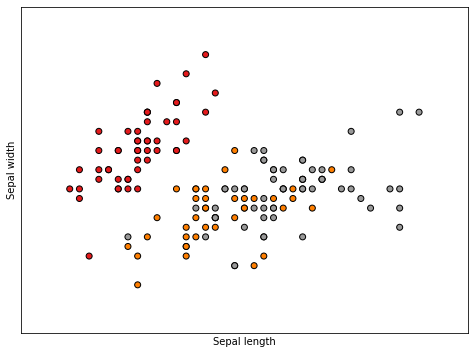

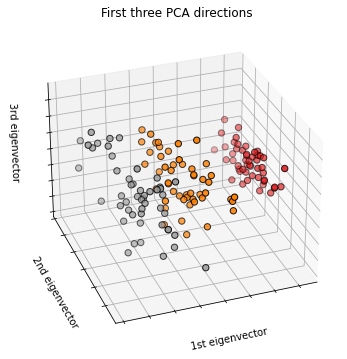

In [59]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

## Appendix
### References
* https://ocw.mit.edu/courses/18-06-linear-algebra-spring-2010/video_galleries/video-lectures/
* https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad
* https://www.kdnuggets.com/2020/05/dimensionality-reduction-principal-component-analysis.html
* 

### Self-assessment
The numbers in brackets define possible points for the corresponding item.

1. Problem statement (0-10)
	* How well is the problem defined?
	* Does the research address a real-life problem?
	* Does the research solve the correct problem?
2. Layout (0-20)
	* Are the document sections structured properly?
	* Is the article well-formatted (in terms of readability)?
3. Code quality (0-20)
	* Is the code well-written? Is the code self-documenting?
	* Is the code organized into functions?
	* Is the code generally well-structured?
4. Previous research (0-10)
	* Have you cited at least two other sources?
	* Does the project contain comparisons between the current and the previous results?
5. Gathering / generating, cleaning, and formatting data (0-10)
	* Every problem deals with "real-world" data in some way. Even if you don't use datasets, you'll likely generate some data
	* How is the data gathered?
	* Is the process statistically valid?
	* Is the process of data acquisition, data cleaning, and data manipulation well documented?
6. Testing (0-10)
	* This can have various meanings: unit testing, hypothesis testing, train / test data set, etc.
	* Is the code thoroughly tested?
	* Are there any comparisons to other implementations / other articles / previous research?
7. Visualization (0-10)
	* All kinds of projects employ some visualization: graphical plots, tables, etc.
	* Are all visualizations correct (i.e. convey the intended meaning without misleading the intended audience)?
	* Are all visualizations clear, and easy to understand?
8. Communication (0-10)
	* Does the project tell the story correctly?
	* Does the project serve the audience it was intended for?